# Electricity Price Analysis

## Import libraries and data read-in

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.ar_model import ar_select_order
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
#read in data from file path.
df_electricity = pd.read_excel('/content/Houston_Electricity_Data.xlsx', sheet_name='Sheet1')


In [3]:
#Evaluate column data types

df_electricity.dtypes

,0
Date,datetime64[ns]
Price per kWH,float64


In [4]:
#Summary of column data

df_electricity[['Date','Price per kWH']]

,Date,Price per kWH
0,1979-01-01,0.035
1,1979-02-01,0.036
2,1979-03-01,0.038
3,1979-04-01,0.038
4,1979-05-01,0.038
...,...,...
543,2024-04-01,0.176
544,2024-05-01,0.185
545,2024-06-01,0.185
546,2024-07-01,0.184


## Descriptive Statistics

Mean: 0.10579470802919708
Median: 0.094
Mode: 0    0.149
Name: Price per kWH, dtype: float64
Variance: 0.0013414874856549992
Standard Deviation: 0.03662632230589087
IQR: 0.05525000000000001


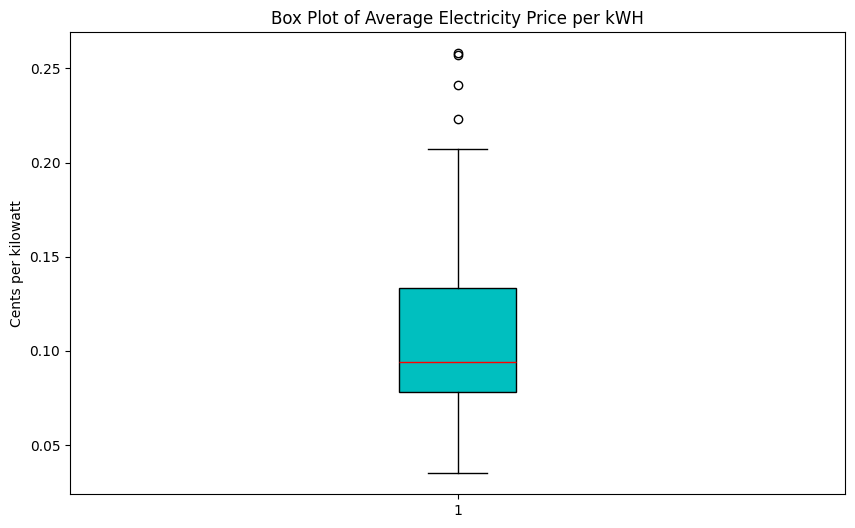

In [5]:
mean_value = df_electricity['Price per kWH'].mean()
print("Mean:", mean_value)

# Median
median_value = df_electricity['Price per kWH'].median()
print("Median:", median_value)

# Mode
mode_value = df_electricity['Price per kWH'].mode()
print("Mode:", mode_value)

# Variance
variance_value = df_electricity['Price per kWH'].var()
print("Variance:", variance_value)

# Standard Deviation
std_dev_value = df_electricity['Price per kWH'].std()
print("Standard Deviation:", std_dev_value)

# Interquartile Range (IQR)
Q1 = df_electricity['Price per kWH'].quantile(0.25)
Q3 = df_electricity['Price per kWH'].quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

plt.figure(figsize=(10, 6))
plt.boxplot(df_electricity['Price per kWH'], patch_artist=True, boxprops=dict(facecolor='c', color='black'),
            whiskerprops=dict(color='black'), capprops=dict(color='black'), medianprops=dict(color='red'))

# Add labels and title
plt.ylabel('Cents per kilowatt')
plt.title('Box Plot of Average Electricity Price per kWH')

# Show the plot
plt.show()

In [6]:
# Breaking the descriptive stats down by year.

df_electricity['Year'] = df_electricity['Date'].dt.year

# Group by year and calculate descriptive statistics
yearly_stats = df_electricity.groupby('Year')['Price per kWH'].agg(['mean', 'median', 'var', 'std', lambda x: x.mode()[0], lambda x: x.quantile(0.75) - x.quantile(0.25)])

yearly_stats.columns = ['Mean', 'Median', 'Variance', 'Std Dev', 'Mode', 'IQR']

pd.options.display.float_format = '{:.6f}'.format

print(yearly_stats)

         Mean   Median  Variance  Std Dev     Mode      IQR
Year                                                       
1979 0.040083 0.039500  0.000011 0.003315 0.038000 0.005000
1980 0.049250 0.048000  0.000029 0.005429 0.055000 0.010000
1981 0.061583 0.064500  0.000069 0.008328 0.066000 0.012750
1982 0.076167 0.078500  0.000075 0.008632 0.084000 0.011500
1983 0.080833 0.082000  0.000093 0.009647 0.074000 0.015250
1984 0.082750 0.089000  0.000060 0.007724 0.089000 0.015000
1985 0.084000 0.085000  0.000042 0.006467 0.088000 0.008750
1986 0.076417 0.078000  0.000024 0.004870 0.080000 0.005250
1987 0.072583 0.072500  0.000036 0.006022 0.067000 0.011000
1988 0.072333 0.072500  0.000036 0.005975 0.066000 0.011250
1989 0.076250 0.076500  0.000074 0.008582 0.065000 0.016500
1990 0.078833 0.079000  0.000042 0.006450 0.085000 0.012000
1991 0.082000 0.082000  0.000086 0.009283 0.071000 0.020000
1992 0.083583 0.082500  0.000101 0.010031 0.078000 0.015000
1993 0.088083 0.089500  0.000063 0.00791

## Data cleaning

In [7]:
#Check for null values

num_null_rows = df_electricity.isnull().any(axis=1).sum()
print(f"Number of rows with at least one null: {num_null_rows}")

Number of rows with at least one null: 0


In [8]:
#Coverting Date Column to DateTime data type

df_electricity['Date'] = pd.to_datetime(df_electricity['Date'], format='%d-%m-%Y')

# Print the updated DataFrame to verify the conversion
print(df_electricity.head())

        Date  Price per kWH  Year
0 1979-01-01       0.035000  1979
1 1979-02-01       0.036000  1979
2 1979-03-01       0.038000  1979
3 1979-04-01       0.038000  1979
4 1979-05-01       0.038000  1979


In [9]:
#Confirming conversion

df_electricity.dtypes

,0
Date,datetime64[ns]
Price per kWH,float64
Year,int32


In [10]:
#Checking for Outliers

#----Tukey IQR function -----
import numpy as np
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.5* iqr
    ceiling = q3 + 1.5* iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices , outlier_values

In [11]:
#applying the function on the DataFrame df_electricity
tukey_indices , tukey_values = find_outliers_tukey(df_electricity['Price per kWH'])

In [12]:
print(tukey_indices, tukey_values)

[521, 522, 523, 524] [0.223, 0.258, 0.257, 0.241]


In [13]:
#testing for outlier at index 521
df_electricity['Price per kWH'].iloc[521]

np.float64(0.223)

In [14]:
# Remove outliers

df_electricity = df_electricity[~df_electricity['Price per kWH'].isin(tukey_values)]


In [15]:
#confirm outlier was removed (should be different from 0.223)
df_electricity['Price per kWH'].iloc[521]

np.float64(0.207)

## Futher data exploration

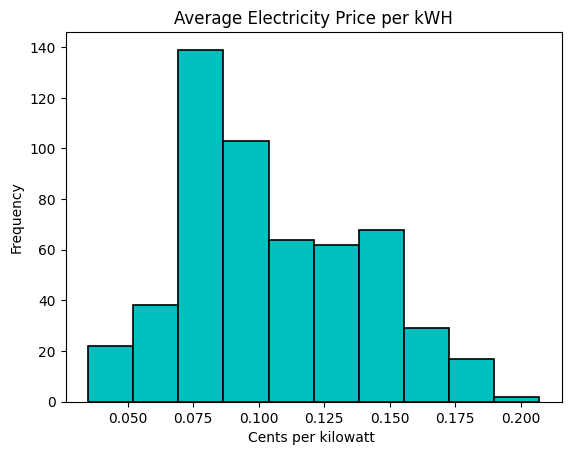

In [16]:
#Plot histogram visualizing distribution of electricity prices

plt.hist(df_electricity['Price per kWH'], color='c', edgecolor='black', linewidth=1.2)
plt.xlabel('Cents per kilowatt ')
plt.ylabel('Frequency')
plt.title('Average Electricity Price per kWH')
plt.savefig('hist_electricity.png')
plt.show()

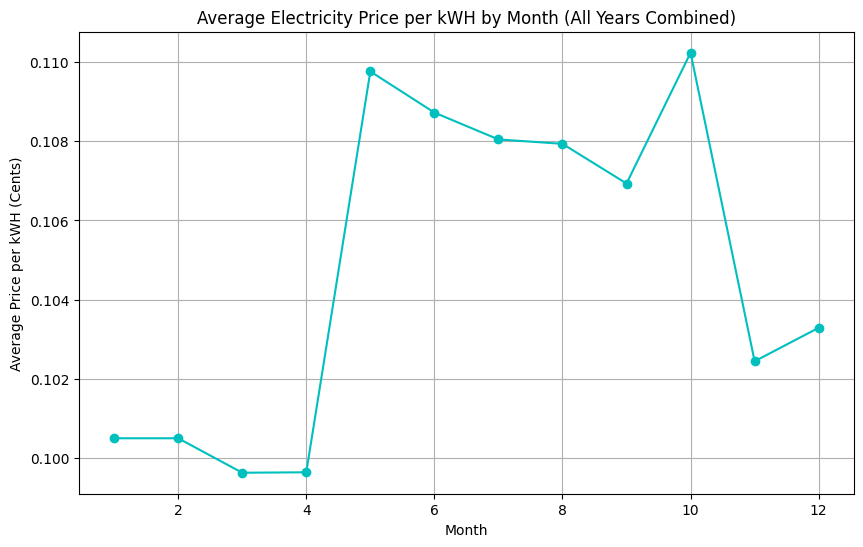

In [17]:
#Time series visualization showing avg electricity price by month (all years combined)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_electricity['Month'] = df_electricity['Date'].dt.month

# Calculate average price per kWH for each month across all years
monthly_prices = df_electricity.groupby('Month')['Price per kWH'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_prices['Month'], monthly_prices['Price per kWH'], marker='o', color='c')

plt.xlabel('Month')
plt.ylabel('Average Price per kWH (Cents)')
plt.title('Average Electricity Price per kWH by Month (All Years Combined)')

plt.grid()
plt.show()

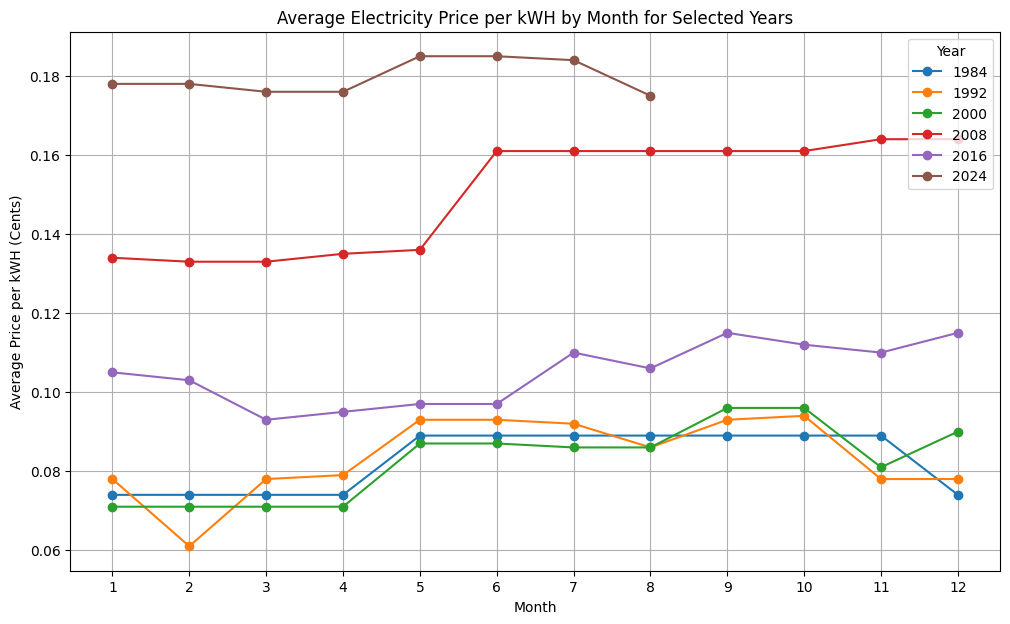

In [18]:
#Seeing how monthly price trends compare across decades (every 6 years from 1984-2024)

# Extract Month and Year from the Date
df_electricity['Month'] = df_electricity['Date'].dt.month
df_electricity['Year'] = df_electricity['Date'].dt.year

# Filter for selected years
selected_years = [1984, 1992, 2000, 2008, 2016, 2024]
filtered_df = df_electricity[df_electricity['Year'].isin(selected_years)]

# Group by Year and Month, then calculate average price per kWH
monthly_avg_by_year = (
    filtered_df.groupby(['Year', 'Month'])['Price per kWH']
    .mean()
    .reset_index()
)

# Plotting
plt.figure(figsize=(12, 7))

# Plot a line for each year
for year in selected_years:
    data = monthly_avg_by_year[monthly_avg_by_year['Year'] == year]
    plt.plot(data['Month'], data['Price per kWH'], marker='o', label=str(year))


plt.xlabel('Month')
plt.ylabel('Average Price per kWH (Cents)')
plt.title('Average Electricity Price per kWH by Month for Selected Years')
plt.legend(title='Year')
plt.grid(True)
plt.xticks(range(1, 13))  # Ensure x-axis shows all months 1-12

plt.show()

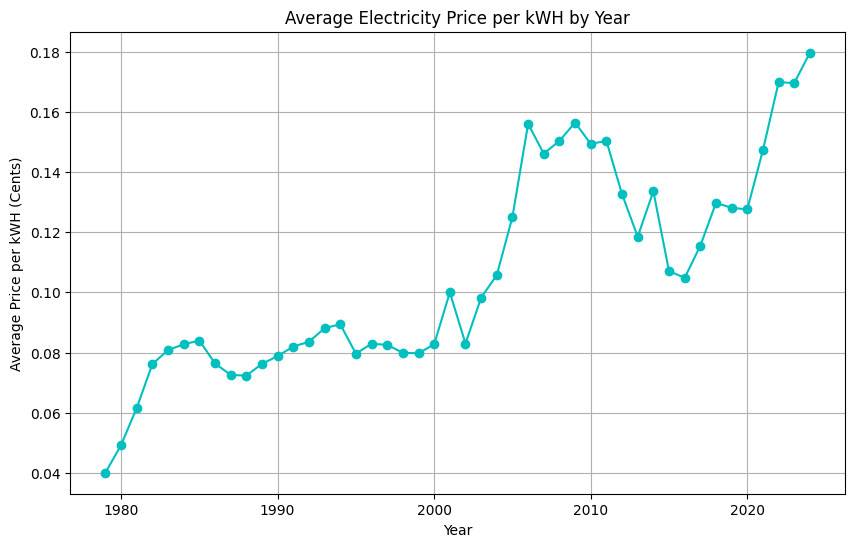

In [19]:
#Time series visualization showing avg electricity price by Year

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_electricity['Date']

df_electricity['Year'] = df_electricity['Date'].dt.year

# Calculate average price per kWH for year
yearly_prices = df_electricity.groupby('Year')['Price per kWH'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_prices['Year'], yearly_prices['Price per kWH'], marker='o', color='c')

plt.xlabel('Year')
plt.ylabel('Average Price per kWH (Cents)')
plt.title('Average Electricity Price per kWH by Year')

plt.grid()
plt.show()

## Cross validation

In [20]:
#Setting the index to Date and extracting the price column and storing as series

df_electricity.set_index('Date', inplace=True)

series = df_electricity['Price per kWH']

In [21]:
#Split data into training and testing sets. 70% of data used for historic (training) and the remaining 30% for testing.

historic = series.iloc[:int(len(series) * 0.7)]
test = series.iloc[int(len(series) * 0.7):]

In [22]:
#Confirming series type
type(historic)

pandas.core.series.Series

In [23]:
#Converting series to list for forecasting
historic = historic.to_list()
type(historic)

list

In [24]:
# Perform one-step-ahead forecast

predictions = []
for i in range(len(test)):
    sel = ar_select_order(historic, 13, old_names=False)
    sel.ar_lags
    model_fit = sel.model.fit()
    pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
    predictions.append(pred[0])
    historic.append(test.iloc[i])
cross_val = pd.Series(predictions, index=test.index)

In [25]:
# Convert predictions to a pandas Series with the same index as the test set
cross_val = pd.Series(predictions, index=test.index)

# Calculate RMSE for the cross-validation
electricity_price_rmse = np.sqrt(mean_squared_error(test, cross_val))
print("RMSE:", electricity_price_rmse)

RMSE: 0.008397662766542925


In [26]:
#Confirm conversion
type(cross_val)

pandas.core.series.Series

In [27]:
#Analyze first several predictions
cross_val.head()

,0
Date,
2010-09-01,0.149496
2010-10-01,0.149196
2010-11-01,0.150091
2010-12-01,0.149338
2011-01-01,0.149373


In [28]:
#Analyze actual values
test.head()

,Price per kWH
Date,
2010-09-01,0.150000
2010-10-01,0.150000
2010-11-01,0.149000
2010-12-01,0.150000
2011-01-01,0.149000


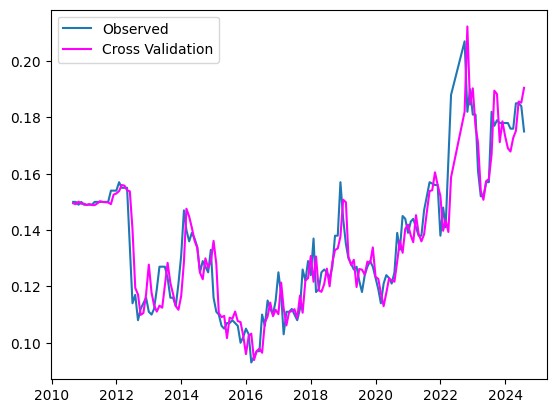

In [29]:
# plot results
plt.plot(test, label='Observed')
plt.plot(cross_val, color='magenta', label='Cross Validation')
plt.legend()
plt.show()

In [30]:
# Create a DataFrame with both observed (test) and predicted (cross_val) values
comparison_df = pd.DataFrame({
    'Observed': test,
    'Predicted': cross_val
})

# Display the DataFrame to check the values
print(comparison_df)

            Observed  Predicted
Date                           
2010-09-01  0.150000   0.149496
2010-10-01  0.150000   0.149196
2010-11-01  0.149000   0.150091
2010-12-01  0.150000   0.149338
2011-01-01  0.149000   0.149373
...              ...        ...
2024-04-01  0.176000   0.172742
2024-05-01  0.185000   0.175181
2024-06-01  0.185000   0.185615
2024-07-01  0.184000   0.185222
2024-08-01  0.175000   0.190507

[164 rows x 2 columns]


In [31]:
# define true and predicted response values
y_true = [0.149000, 0.185000, 0.175000]
y_pred = [0.148900, 0.184130, 0.189233]

# Calculate MAE and MSE
print("MAE:", metrics.mean_absolute_error(y_true, y_pred))
print("MSE:", metrics.mean_squared_error(y_true, y_pred))

# RMSE: manually take sqrt of MSE
rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

# MAPE: calculate manually
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)
mape = np.mean(np.abs((y_true_np - y_pred_np) / y_true_np)) * 100
print("MAPE:", mape)


MAE: 0.005067666666666674
MSE: 6.778172966666688e-05
RMSE: 0.008232966030943338
MAPE: 2.8901757404576234


## Prediction for the future

In [32]:
# Reassign monthly start frequency explicitly
series.index = pd.to_datetime(series.index)
series.index = pd.DatetimeIndex(series.index).to_period('M')

In [33]:
# Confirm frequency as monthly
print(series.index.freq)

<MonthEnd>


In [34]:
#existing data df_electricity['Price per kWH']
historic = series

#prediction for the next 60 months (5 years)
n_pred = 60
#the future month starts on 2024-09-01, because the last existing data ends on 2024-08-01
date_pred = pd.date_range("2024-09-01", periods=n_pred, freq="MS")

sel = ar_select_order(historic, 13, glob = True)
sel.ar_lags
model_fit = sel.model.fit()
pred = model_fit.predict(start=len(historic), end=len(historic) + n_pred - 1, dynamic=False)

In [35]:
#Analyze the predictions
predictions = pd.Series(pred.values, index=date_pred)
print(predictions)

2024-09-01   0.175128
2024-10-01   0.175655
2024-11-01   0.173049
2024-12-01   0.171406
2025-01-01   0.171840
2025-02-01   0.173603
2025-03-01   0.174228
2025-04-01   0.173524
2025-05-01   0.176232
2025-06-01   0.176014
2025-07-01   0.175381
2025-08-01   0.171821
2025-09-01   0.171580
2025-10-01   0.171393
2025-11-01   0.169913
2025-12-01   0.168895
2026-01-01   0.169164
2026-02-01   0.170208
2026-03-01   0.170642
2026-04-01   0.170029
2026-05-01   0.170852
2026-06-01   0.170681
2026-07-01   0.170196
2026-08-01   0.168512
2026-09-01   0.168061
2026-10-01   0.167771
2026-11-01   0.167026
2026-12-01   0.166428
2027-01-01   0.166478
2027-02-01   0.166919
2027-03-01   0.167072
2027-04-01   0.166647
2027-05-01   0.166806
2027-06-01   0.166612
2027-07-01   0.166224
2027-08-01   0.165322
2027-09-01   0.164893
2027-10-01   0.164623
2027-11-01   0.164207
2027-12-01   0.163821
2028-01-01   0.163744
2028-02-01   0.163858
2028-03-01   0.163845
2028-04-01   0.163539
2028-05-01   0.163453
2028-06-01

In [36]:
#Convert Period Index to Timestamp for matplotlib visualization
series.index = series.index.to_timestamp()

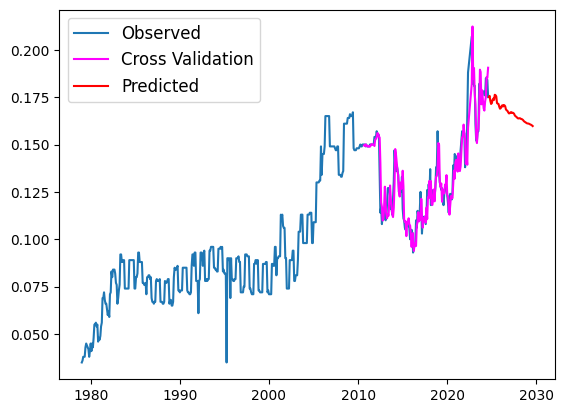

In [38]:
# plot results
plt.plot(series, label='Observed')
plt.plot(cross_val, color='magenta', label='Cross Validation')
plt.plot(predictions, color='red', label='Predicted')
plt.legend(fontsize = 12)
plt.show()

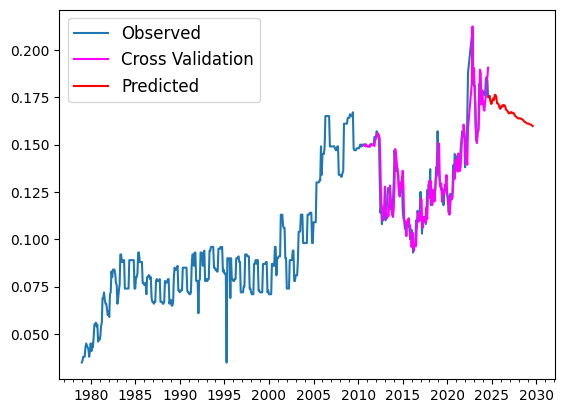

In [39]:
import matplotlib.dates as mdates

# Setting major ticks to show every 5 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Plot data again
plt.plot(series, label='Observed')
plt.plot(cross_val, color='magenta', label='Cross Validation')
plt.plot(predictions, color='red', label='Predicted')
plt.legend(fontsize=12)
plt.show()